# Lista de Exercícios com Machine Learning Modelos Avançados

Exercícios de Programação em Python para Machine Learning

Aluna: Larissa Lucena de Oliveira

In [ ]:
# Instalar biblioteca
!pip install tpot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 893.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.5 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=99807756fbb0ece62950fb9836dd258b61b7c59b24d31f0d5822fd9c86be225c
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [ ]:
# Importar bibliotecas
from io import StringIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pydotplus
from IPython.display import Image
from scipy.stats import mode

from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    cross_val_score,
    StratifiedKFold
)
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.pipeline import Pipeline
from tpot import TPOTClassifier

In [ ]:
# Carregar dataset
iris = load_iris()
X = iris.data
y = iris.target

# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## PCA (Análise de Componentes Principais)
Implemente um algoritmo de PCA a partir do zero. Utilize um conjunto de dados de sua escolha e reduza a dimensionalidade para duas dimensões. Visualize os dados originais e os dados transformados.

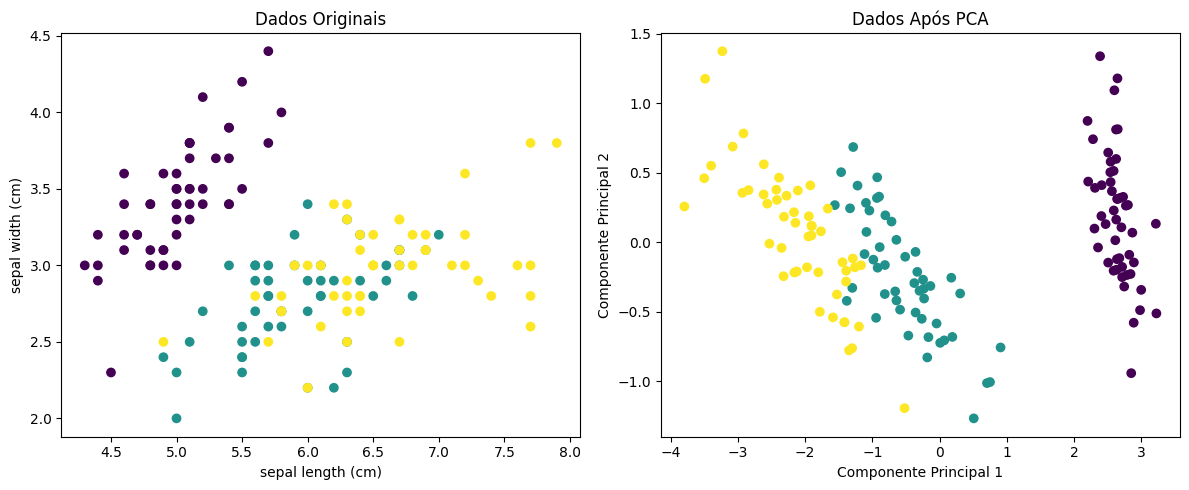

In [ ]:
# Estandarizar os dados
X_meaned = X - np.mean(X, axis=0)

# Calcular a matriz de covariância
cov_mat = np.cov(X_meaned, rowvar=False)

# Calcular autovalores e autovetores
eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

# Ordenar
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalues = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:, sorted_index]

# Selecionar os dois principais autovetores
eigenvector_subset = sorted_eigenvectors[:, 0:2]

# Transformar os dados
X_reduced = np.dot(eigenvector_subset.transpose(), X_meaned.transpose()).transpose()

# Visualizar os dados originais e transformados
plt.figure(figsize=(12, 5))

# Dados originais
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Dados Originais')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])

# Dados após PCA
plt.subplot(1, 2, 2)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)
plt.title('Dados Após PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.tight_layout()
plt.show()


## PCA com Scikit-Learn
Utilize o PCA da biblioteca Scikit-Learn em um conjunto de dados como o Iris. Compare a variância explicada pelos componentes principais e visualize os dados reduzidos.

Variância explicada: [0.72962445 0.22850762]


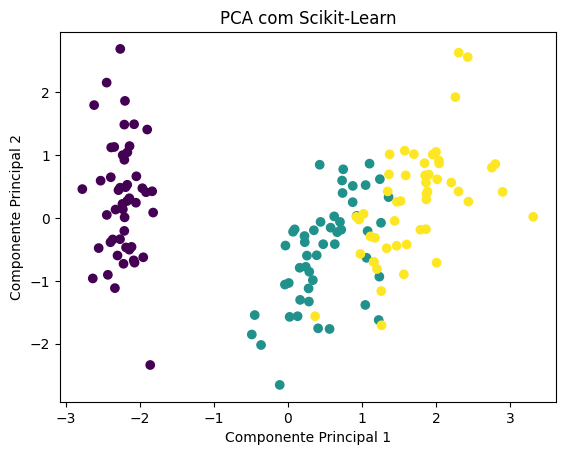

In [ ]:
# Estandarizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Variância explicada por cada componente principal
print('Variância explicada:', pca.explained_variance_ratio_)

# Visualização dos dados reduzidos
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.title('PCA com Scikit-Learn')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()


## LDA (Análise Discriminante Linear)
Implemente o LDA para um conjunto de dados que possua mais de duas classes. Visualize a separação entre as classes após a transformação dos dados.

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


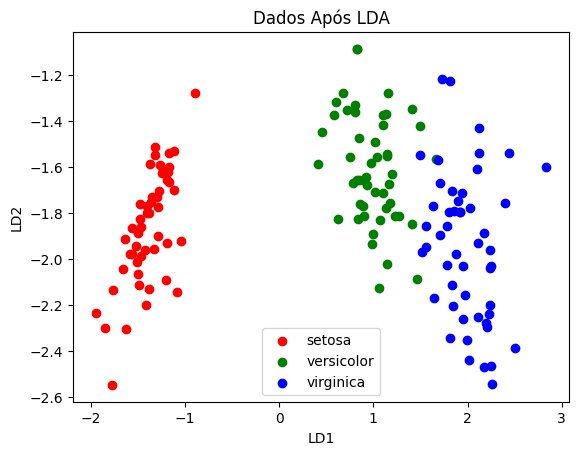

In [ ]:
# Calcular a média por classe
mean_vectors = []
classes = np.unique(y)
for cl in classes:
    mean_vectors.append(np.mean(X[y == cl], axis=0))

# Calcular a matriz de dispersão intra-classes (SW)
S_W = np.zeros((X.shape[1], X.shape[1]))
for cl, mv in zip(classes, mean_vectors):
    class_sc_mat = np.zeros((X.shape[1], X.shape[1]))
    for row in X[y == cl]:
        row, mv = row.reshape(X.shape[1],1), mv.reshape(X.shape[1],1)
        class_sc_mat += (row - mv).dot((row - mv).T)
    S_W += class_sc_mat

# Calcular a matriz de dispersão entre-classes (SB)
overall_mean = np.mean(X, axis=0).reshape(X.shape[1],1)
S_B = np.zeros((X.shape[1], X.shape[1]))
for i, mean_vec in enumerate(mean_vectors):
    n = X[y == i, :].shape[0]
    mean_vec = mean_vec.reshape(X.shape[1],1)
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

# Resolver o problema de autovalores para inv(SW) * SB
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Ordenar autovalores e autovetores
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)

# Selecionar os autovetores com maiores autovalores
W = np.hstack((pairs[0][1].reshape(X.shape[1],1), pairs[1][1].reshape(X.shape[1],1)))

# Transformar os dados
X_lda = X.dot(W)

# Visualizar a separação entre as classes
plt.figure()
colors = ['r', 'g', 'b']
for label, color in zip(classes, colors):
    plt.scatter(X_lda[y == label, 0], X_lda[y == label, 1], label=iris.target_names[label], c=color)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.title('Dados Após LDA')
plt.show()


## LDA com Scikit-Learn
Use o LDA da biblioteca Scikit-Learn em um conjunto de dados e avalie a precisão do modelo resultante em uma tarefa de classificação.

Precisão do Modelo LDA: 1.0


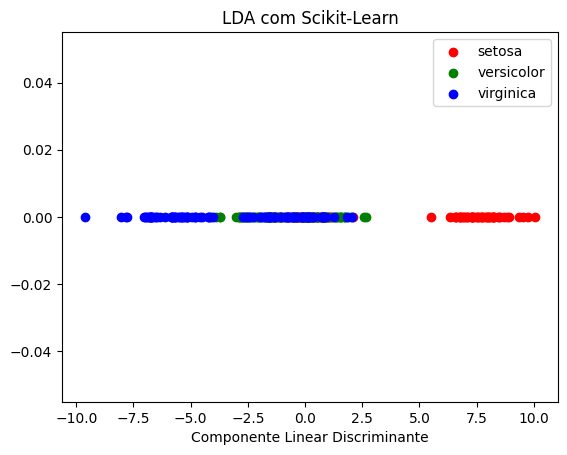

In [ ]:
# Aplicar LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

# Avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Precisão do Modelo LDA:', accuracy)

# Transformar os dados para visualização
X_lda = lda.transform(X)

# Visualizar os dados transformados
plt.figure()
for label, color in zip(classes, colors):
    plt.scatter(X_lda[y == label], np.zeros_like(X_lda[y == label]), label=iris.target_names[label], c=color)
plt.xlabel('Componente Linear Discriminante')
plt.legend()
plt.title('LDA com Scikit-Learn')
plt.show()

## Sistemas de Recomendação: Filtragem Colaborativa
Construa um sistema de recomendação baseado em filtragem colaborativa usando um conjunto de dados de avaliações de filmes. Utilize tanto a abordagem baseada em usuário quanto a baseada em item.



In [ ]:
# Criar dataset com avaliações
filmes = {
    'Usuário': ['Ana', 'Bruno', 'Carla', 'Daniel', 'Eduarda'],
    'Filme1': [5, 3, np.nan, 1, 4],
    'Filme2': [4, np.nan, 2, 2, 5],
    'Filme3': [1, 2, 3, np.nan, 4],
    'Filme4': [np.nan, 5, 4, 3, 2],
    'Filme5': [2, 1, 5, 4, np.nan],
}

df = pd.DataFrame(filmes)
df.set_index('Usuário', inplace=True)

# Substituir NaN por 0 para o cálculo
matriz_avaliacoes = df.fillna(0)

# Cálculo da similaridade entre usuários
similaridade_usuarios = pd.DataFrame(cosine_similarity(matriz_avaliacoes),
                                     index=matriz_avaliacoes.index,
                                     columns=matriz_avaliacoes.index)

# Função para prever a avaliação baseada em usuário
def prever_avaliacao_usuario(usuario_alvo, filme_alvo):
    usuarios_que_avaliaram = df[df[filme_alvo].notna()].index
    similaridades = similaridade_usuarios.loc[usuario_alvo, usuarios_que_avaliaram]
    avaliacoes = df.loc[usuarios_que_avaliaram, filme_alvo]
    numerador = (similaridades * avaliacoes).sum()
    denominador = similaridades.sum()
    if denominador == 0:
        return np.nan
    return numerador / denominador

# Previsão para "Carla" e "Filme1" baseada em usuário
previsao_usuario = prever_avaliacao_usuario('Carla', 'Filme1')

# Transposição da matriz para calcular similaridade entre itens
matriz_avaliacoes_T = matriz_avaliacoes.T

# Cálculo da similaridade entre itens
similaridade_itens = pd.DataFrame(cosine_similarity(matriz_avaliacoes_T),
                                  index=matriz_avaliacoes_T.index,
                                  columns=matriz_avaliacoes_T.index)

# Função para prever a avaliação baseada em item
def prever_avaliacao_item(usuario_alvo, filme_alvo):
    filmes_avaliados = df.columns[df.loc[usuario_alvo].notna()]
    similaridades = similaridade_itens.loc[filme_alvo, filmes_avaliados]
    avaliacoes = df.loc[usuario_alvo, filmes_avaliados]
    numerador = (similaridades * avaliacoes).sum()
    denominador = similaridades.sum()
    if denominador == 0:
        return np.nan
    return numerador / denominador

# Previsão para "Carla" e "Filme1" baseada em item
previsao_item = prever_avaliacao_item('Carla', 'Filme1')

# Impressão dos resultados
print('Matriz de Avaliações:')
print(df)
print('\nSimilaridade entre Usuários:')
print(similaridade_usuarios)
print(f'\nPrevisão de avaliação de Carla para o Filme1 (Baseada em Usuário): {previsao_usuario:.2f}')
print('\nSimilaridade entre Itens:')
print(similaridade_itens)
print(f'\nPrevisão de avaliação de Carla para o Filme1 (Baseada em Item): {previsao_item:.2f}')

Matriz de Avaliações:
         Filme1  Filme2  Filme3  Filme4  Filme5
Usuário                                        
Ana         5.0     4.0     1.0     NaN     2.0
Bruno       3.0     NaN     2.0     5.0     1.0
Carla       NaN     2.0     3.0     4.0     5.0
Daniel      1.0     2.0     NaN     3.0     4.0
Eduarda     4.0     5.0     4.0     2.0     NaN

Similaridade entre Usuários:
Usuário       Ana     Bruno     Carla    Daniel   Eduarda
Usuário                                                  
Ana      1.000000  0.448583  0.421350  0.565301  0.830632
Bruno    0.448583  1.000000  0.675511  0.643176  0.615069
Carla    0.421350  0.675511  1.000000  0.894427  0.522708
Daniel   0.565301  0.643176  0.894427  1.000000  0.467525
Eduarda  0.830632  0.615069  0.522708  0.467525  1.000000

Previsão de avaliação de Carla para o Filme1 (Baseada em Usuário): 2.83

Similaridade entre Itens:
          Filme1    Filme2    Filme3    Filme4    Filme5
Filme1  1.000000  0.840168  0.690268  0.495440  0

## Sistemas de Recomendação: Filtragem Baseada em Conteúdo
Implemente um sistema de recomendação baseado em conteúdo usando um conjunto de dados de produtos (como artigos de e-commerce). Utilize características descritivas dos produtos para fazer recomendações.



In [ ]:
# Criar dataset com produtos e descrições
produtos = {
    'ProdutoID': [1, 2, 3, 4, 5],
    'Nome': ['Camisa Polo', 'Calça Jeans', 'Sapato Social', 'Camiseta Esportiva', 'Tênis de Corrida'],
    'Descrição': [
        'Camisa polo masculina de algodão',
        'Calça jeans azul escura',
        'Sapato social de couro preto',
        'Camiseta esportiva de poliéster',
        'Tênis de corrida com amortecimento'
    ]
}

df = pd.DataFrame(produtos)

# Vetorização das descrições usando TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['Descrição'])

# Cálculo da similaridade do cosseno entre os produtos
similaridade = cosine_similarity(tfidf_matrix)

# Função para recomendar produtos similares
def recomendar_produtos(produto_id, matriz_similaridade, df_produtos, num_recomendacoes=2):
    indice_produto = df_produtos.index[df_produtos['ProdutoID'] == produto_id][0]
    scores_similaridade = list(enumerate(matriz_similaridade[indice_produto]))
    scores_similaridade = sorted(scores_similaridade, key=lambda x: x[1], reverse=True)
    recomendacoes_indices = [i[0] for i in scores_similaridade[1:num_recomendacoes+1]]
    produtos_recomendados = df_produtos.iloc[recomendacoes_indices]
    return produtos_recomendados

# Exemplo de recomendação para o produto com ID 1
produto_id = 1
recomendacoes = recomendar_produtos(produto_id, similaridade, df)
print(f"Produtos recomendados para '{df[df['ProdutoID'] == produto_id]['Nome'].values[0]}':")
print(recomendacoes[['ProdutoID', 'Nome']])

Produtos recomendados para 'Camisa Polo':
   ProdutoID                Nome
3          4  Camiseta Esportiva
2          3       Sapato Social


## AutoML: Introdução
Utilize uma biblioteca de AutoML (como Auto-sklearn ou TPOT) para automatizar o processo de modelagem em um conjunto de dados de classificação. Compare os resultados com modelos tradicionais que você treinou manualmente.



In [ ]:
# Automated modeling with TPOT
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
y_pred_tpot = tpot.predict(X_test)
accuracy_tpot = accuracy_score(y_test, y_pred_tpot)

# Logistic Regression
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=200, random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Compare the results
print('Accuracy of TPOT model:', accuracy_tpot)
print('Accuracy of Logistic Regression:', accuracy_lr)
print('Accuracy of Random Forest:', accuracy_rf)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.975

Generation 2 - Current best internal CV score: 0.975

Generation 3 - Current best internal CV score: 0.975

Generation 4 - Current best internal CV score: 0.975

Generation 5 - Current best internal CV score: 0.975

Best pipeline: MLPClassifier(input_matrix, alpha=0.0001, learning_rate_init=0.001)
Accuracy of TPOT model: 1.0
Accuracy of Logistic Regression: 1.0
Accuracy of Random Forest: 1.0


## AutoML: Hyperparameter Tuning
Realize a otimização de hiperparâmetros utilizando uma ferramenta de AutoML em um modelo de árvore de decisão ou floresta aleatória. Avalie o desempenho do modelo otimizado.



In [ ]:
# Configuração do TPOT para otimizar hiperparâmetros do Random Forest
tpot = TPOTClassifier(
    generations=5,
    population_size=50,
    verbosity=2,
    random_state=42,
    config_dict={
        'sklearn.ensemble.RandomForestClassifier': {
            'n_estimators': [10, 50, 100],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ["gini", "entropy"],
        }
    }
)

# Treinamento do modelo otimizado
tpot.fit(X_train, y_train)

# Avaliação do desempenho do modelo otimizado
y_pred = tpot.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Acurácia do modelo otimizado:', accuracy)

# Exportação do melhor modelo encontrado
tpot.export('tpot_best_model.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9583333333333334

Generation 2 - Current best internal CV score: 0.9583333333333334

Generation 3 - Current best internal CV score: 0.9583333333333334

Generation 4 - Current best internal CV score: 0.9583333333333334

Generation 5 - Current best internal CV score: 0.9583333333333334

Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, input_matrix), criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50)
Acurácia do modelo otimizado: 1.0


## Métodos Ensemble: Bagging
Implemente o método Bagging (Bootstrap Aggregating) a partir do zero usando árvores de decisão. Compare a precisão do modelo Bagging com uma única árvore de decisão.




In [ ]:
# Implementação do Bagging a partir do zero
n_estimators = 10  # Número de árvores no ensemble
n_samples = X_train.shape[0]  # Número de amostras em cada bootstrap
models = []  # Lista para armazenar os modelos individuais

for i in range(n_estimators):
    # Criação de uma amostra bootstrap
    indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
    X_bootstrap = X_train[indices]
    y_bootstrap = y_train[indices]

    # Treinamento da árvore de decisão na amostra bootstrap
    clf = DecisionTreeClassifier(random_state=i)
    clf.fit(X_bootstrap, y_bootstrap)
    models.append(clf)

# Predições no conjunto de teste usando cada modelo
predictions = []
for clf in models:
    pred = clf.predict(X_test)
    predictions.append(pred)

# Conversão das predições em um array numpy
predictions = np.array(predictions)

# Agregação das predições por votação majoritária
y_pred_bagging, _ = mode(predictions, axis=0)
y_pred_bagging = y_pred_bagging.flatten()

# Avaliação da precisão do modelo Bagging
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)

# Treinamento de uma única árvore de decisão
clf_single = DecisionTreeClassifier(random_state=42)
clf_single.fit(X_train, y_train)
y_pred_single = clf_single.predict(X_test)
accuracy_single = accuracy_score(y_test, y_pred_single)

# Impressão das precisões
print(f'Acurácia do modelo Bagging: {accuracy_bagging:.4f}')
print(f'Acurácia de uma única Árvore de Decisão: {accuracy_single:.4f}')

Acurácia do modelo Bagging: 1.0000
Acurácia de uma única Árvore de Decisão: 1.0000


## Métodos Ensemble: Random Forest
Utilize a biblioteca Scikit-Learn para criar um modelo de Random Forest em um conjunto de dados de sua escolha. Avalie a importância das características e visualize as árvores individuais.



<ipython-input-14-c8394e6b343f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grou

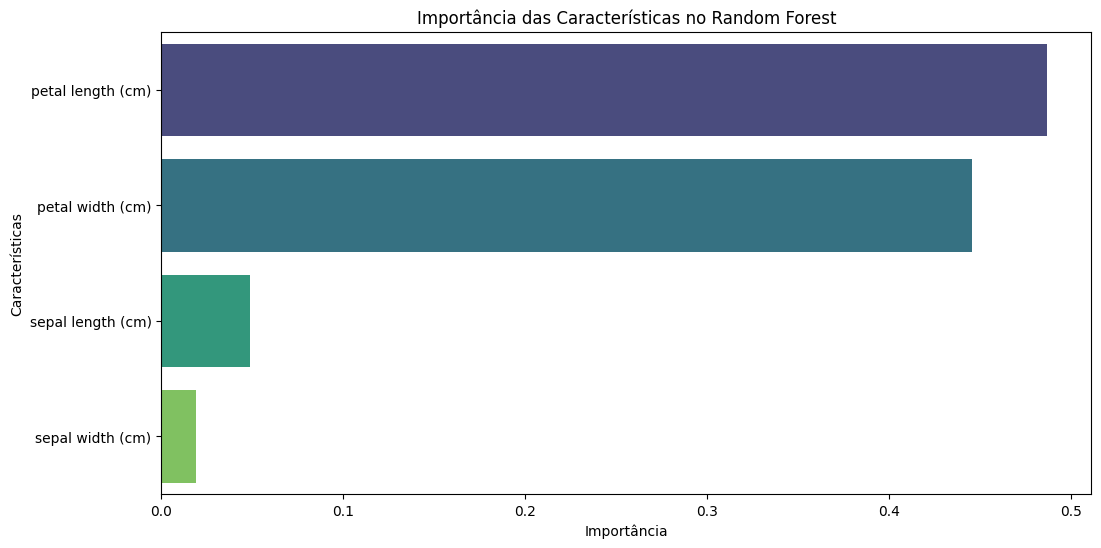

Árvore 1


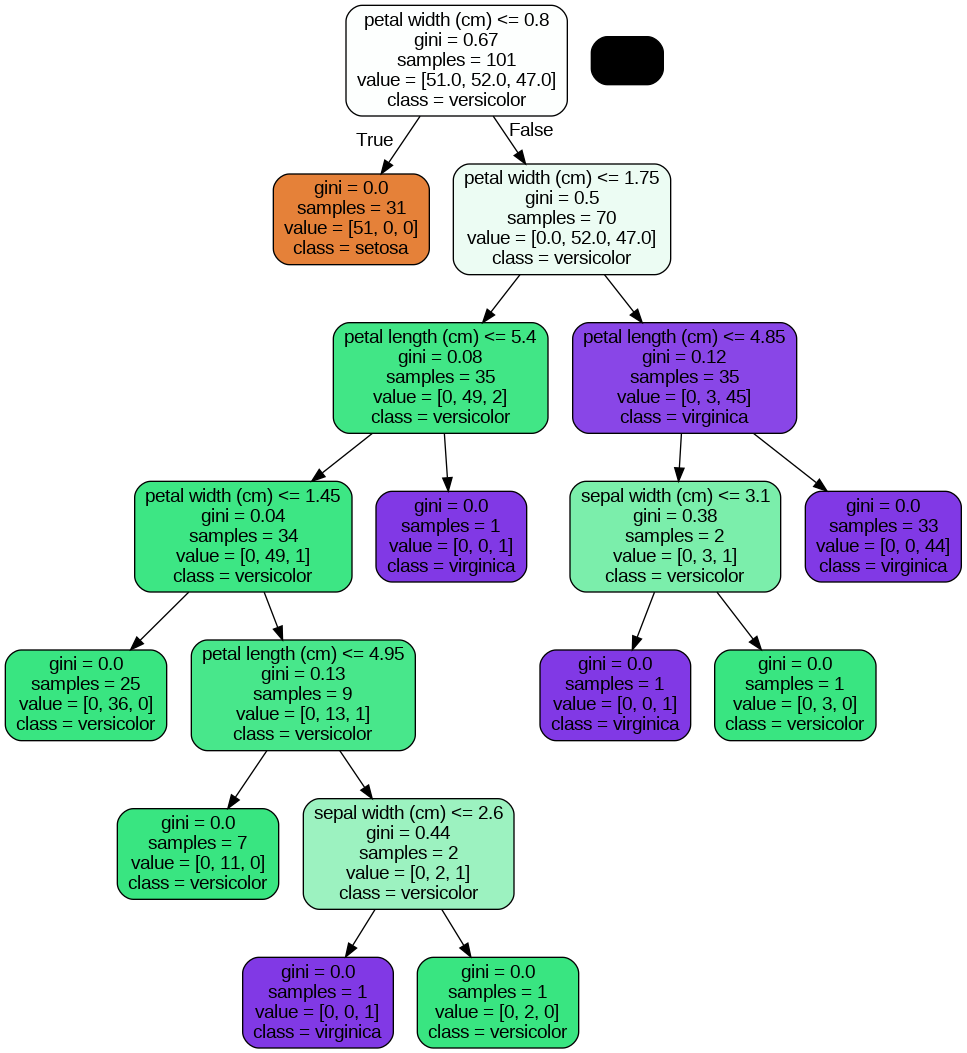

Árvore 2


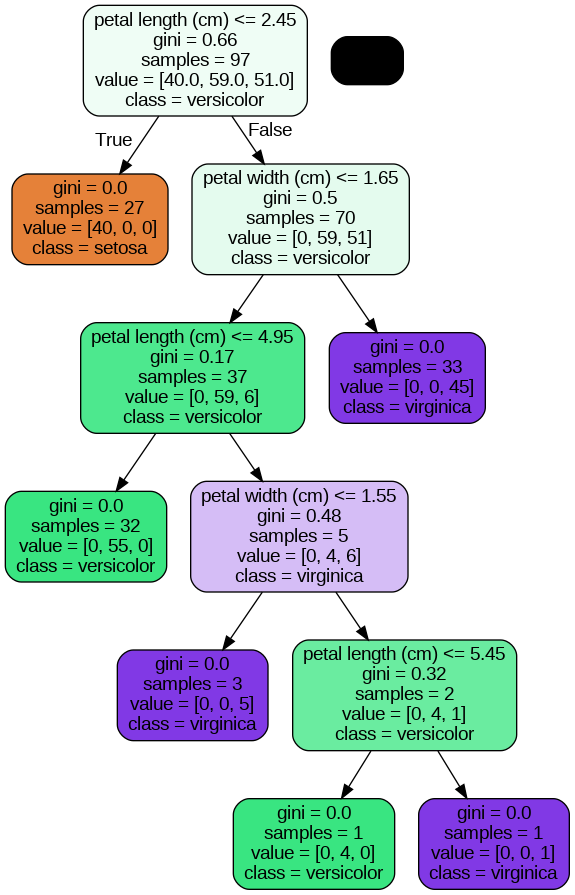

Árvore 3


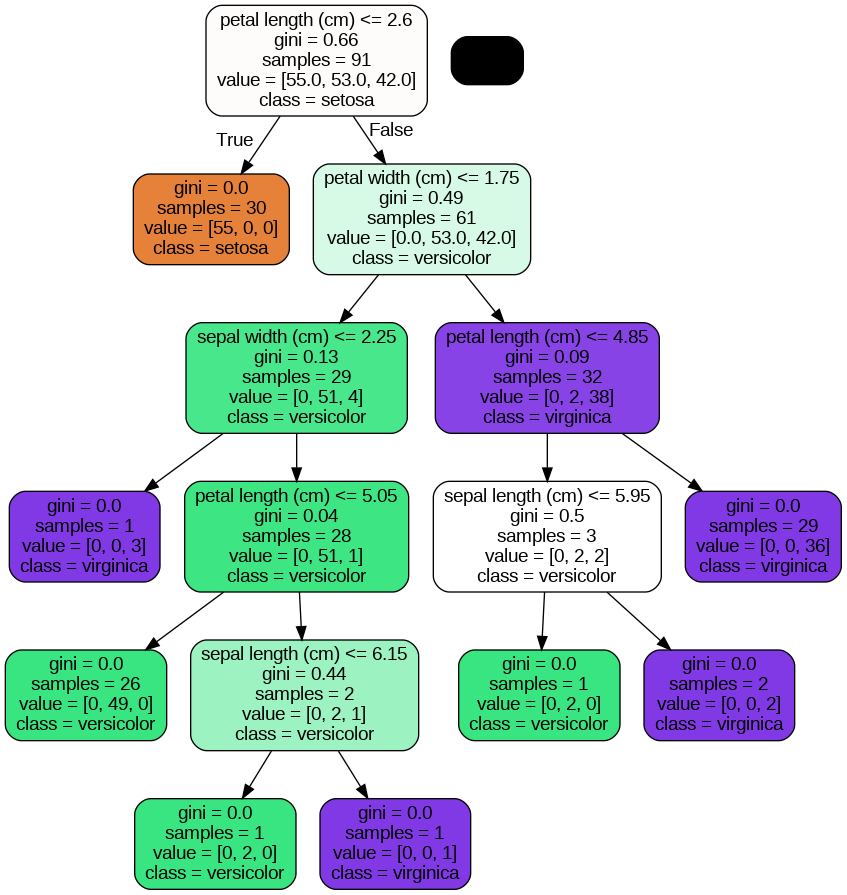

Árvore 4


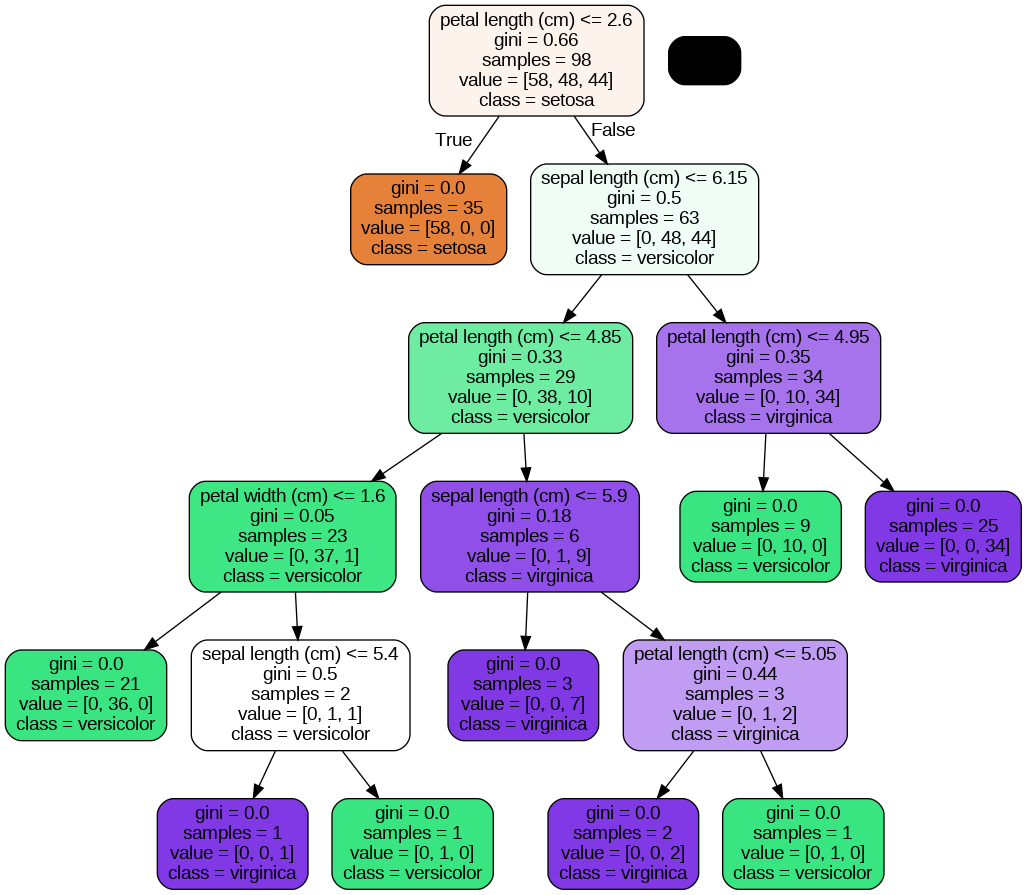

Árvore 5


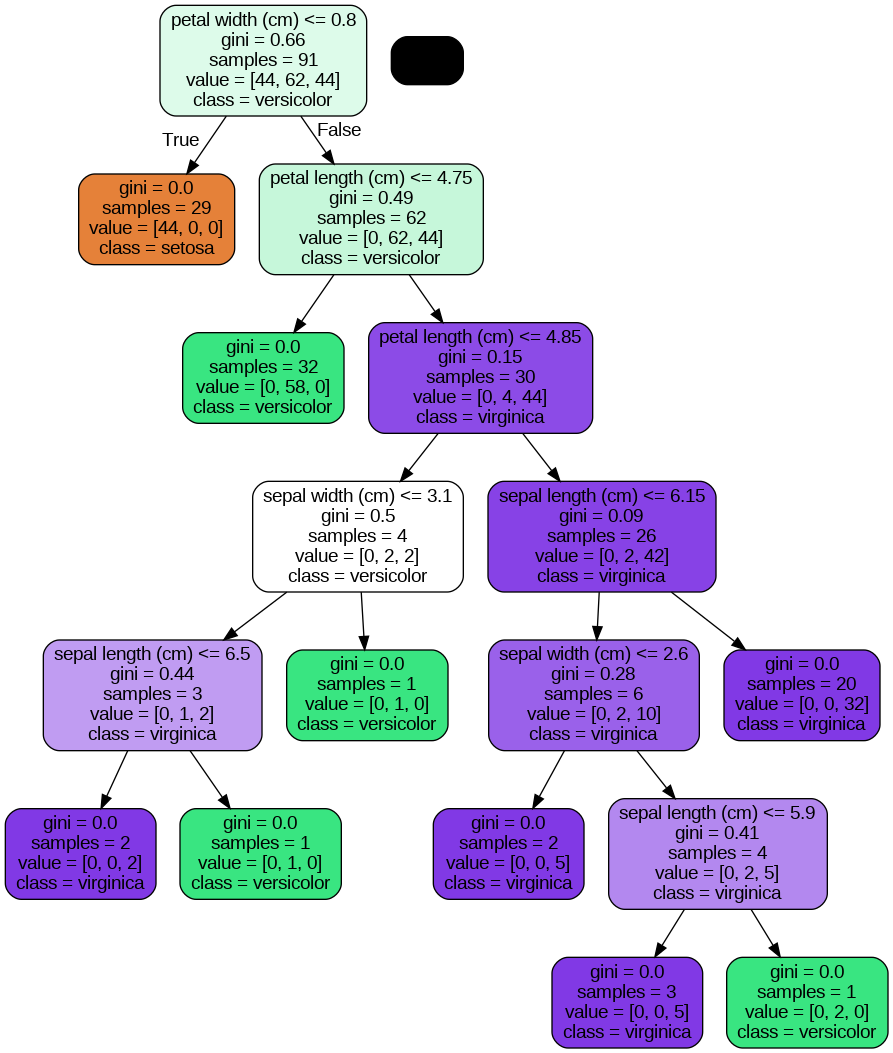

In [ ]:
# Criação do modelo Random Forest
rf = RandomForestClassifier(n_estimators=5, random_state=42)
rf.fit(X, y)

# Avaliação da importância das características
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = pd.Series(iris.feature_names)

# Visualização das importâncias das características
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title('Importância das Características no Random Forest')
plt.xlabel('Importância')
plt.ylabel('Características')
plt.show()

# Visualização das árvores individuais
for i in range(len(rf.estimators_)):
    estimator = rf.estimators_[i]
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=feature_names,
                    class_names=iris.target_names, rounded=True, proportion=False,
                    precision=2, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    print(f'Árvore {i+1}')
    display(Image(graph.create_png()))

## Métodos Ensemble: Boosting
Implemente um modelo de Boosting, como AdaBoost ou Gradient Boosting, em um conjunto de dados. Compare o desempenho do modelo Boosting com um modelo de árvore de decisão simples.



In [ ]:
# Modelo de Árvore de Decisão Simples
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print('Desempenho da Árvore de Decisão Simples:')
print(f'Acurácia: {accuracy_dt:.4f}')
print(classification_report(y_test, y_pred_dt))

# Modelo de AdaBoost com Árvore de Decisão como estimador base
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print('\nDesempenho do Modelo AdaBoost:')
print(f'Acurácia: {accuracy_ada:.4f}')
print(classification_report(y_test, y_pred_ada))

# Modelo de Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print('\nDesempenho do Modelo Gradient Boosting:')
print(f'Acurácia: {accuracy_gb:.4f}')
print(classification_report(y_test, y_pred_gb))

Desempenho da Árvore de Decisão Simples:
Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Desempenho do Modelo AdaBoost:
Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Desempenho do Modelo Gradient Boosting:
Acurácia: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Comparação de Métodos Ensemble
Compare o desempenho de diferentes métodos ensemble (Bagging, Boosting, Random Forest) em um mesmo conjunto de dados. Visualize as curvas de aprendizado e faça uma análise comparativa.




Modelo: Bagging
Acurácia no conjunto de teste: 1.0000


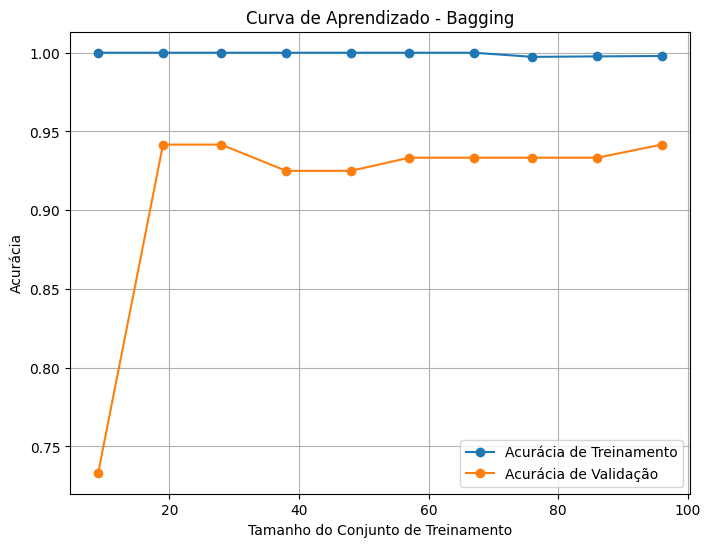


Modelo: Random Forest
Acurácia no conjunto de teste: 1.0000


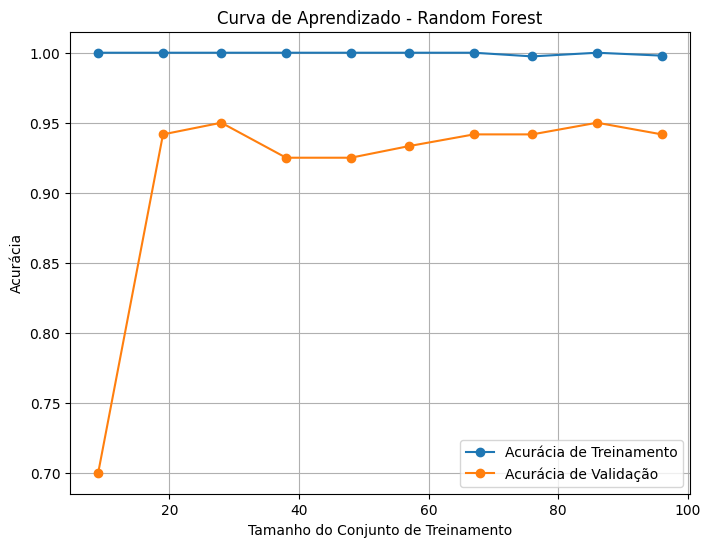


Modelo: Boosting (AdaBoost)
Acurácia no conjunto de teste: 1.0000


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


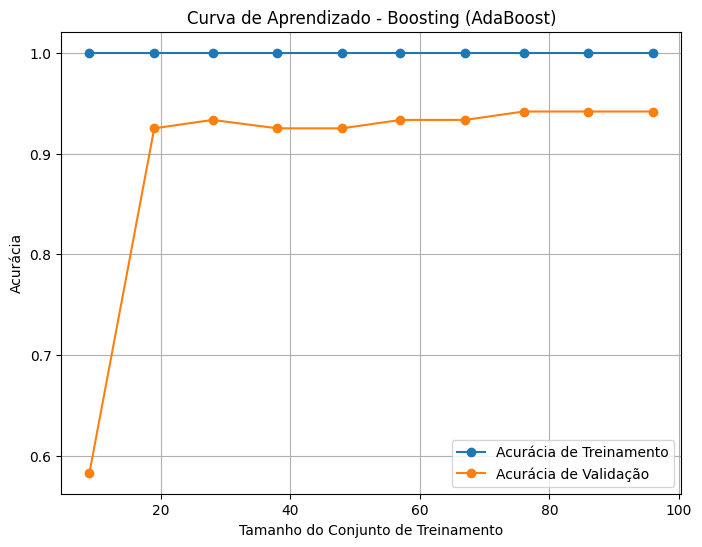

In [ ]:
# Definição dos modelos (substituindo 'base_estimator' por 'estimator')
models = {
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'Boosting (AdaBoost)': AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
}

# Função para plotar as curvas de aprendizado
def plot_learning_curves(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Acurácia de Treinamento')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Acurácia de Validação')
    plt.title(f'Curva de Aprendizado - {model_name}')
    plt.xlabel('Tamanho do Conjunto de Treinamento')
    plt.ylabel('Acurácia')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Avaliação e plotagem das curvas de aprendizado para cada modelo
for name, model in models.items():
    print(f'\nModelo: {name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Acurácia no conjunto de teste: {accuracy:.4f}')
    plot_learning_curves(model, X_train, y_train, name)

## Análise de Resultados de PCA
Após aplicar PCA em um conjunto de dados, analise a contribuição de cada componente principal e como isso afeta a interpretação dos dados.



Variância explicada por cada componente principal: [0.72962445 0.22850762 0.03668922 0.00517871]
Variância explicada acumulada: [0.72962445 0.95813207 0.99482129 1.        ]


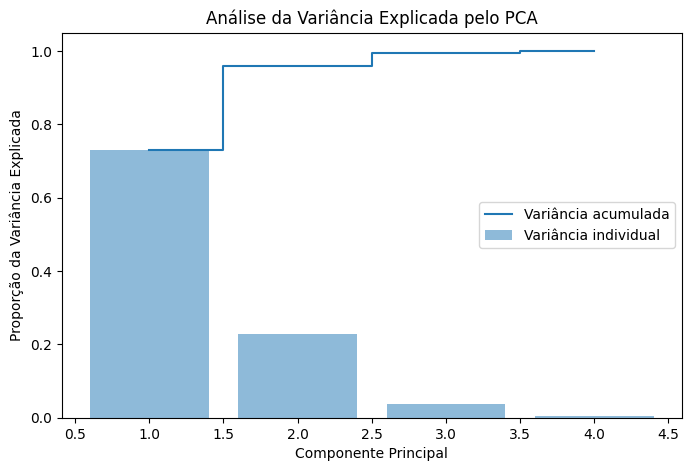

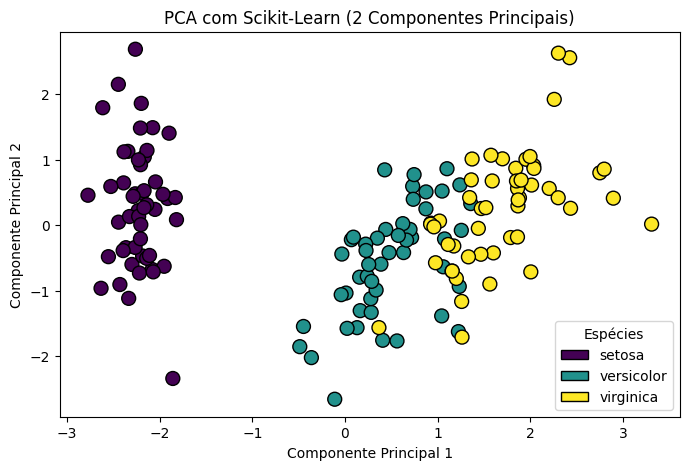

In [ ]:
# Estandarizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Variância explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print('Variância explicada por cada componente principal:', explained_variance)
print('Variância explicada acumulada:', cumulative_variance)

# Visualização da variância explicada
plt.figure(figsize=(8,5))
plt.bar(range(1,5), explained_variance, alpha=0.5, align='center', label='Variância individual')
plt.step(range(1,5), cumulative_variance, where='mid', label='Variância acumulada')
plt.xlabel('Componente Principal')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Análise da Variância Explicada pelo PCA')
plt.legend(loc='best')
plt.show()

# Visualização dos dados reduzidos para 2 componentes principais
plt.figure(figsize=(8,5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=100)
plt.title('PCA com Scikit-Learn (2 Componentes Principais)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Criar a legenda manualmente
colors = [scatter.cmap(scatter.norm(i)) for i in np.unique(y)]
target_names = iris.target_names
legend_elements = [Patch(facecolor=colors[i], edgecolor='k', label=target_names[i]) for i in range(len(target_names))]
plt.legend(handles=legend_elements, title='Espécies')
plt.show()

## Análise de Resultados de LDA
Após aplicar LDA em um conjunto de dados, analise como as classes estão separadas e discuta o impacto das variáveis na discriminação das classes.



Precisão do Modelo LDA: 1.0


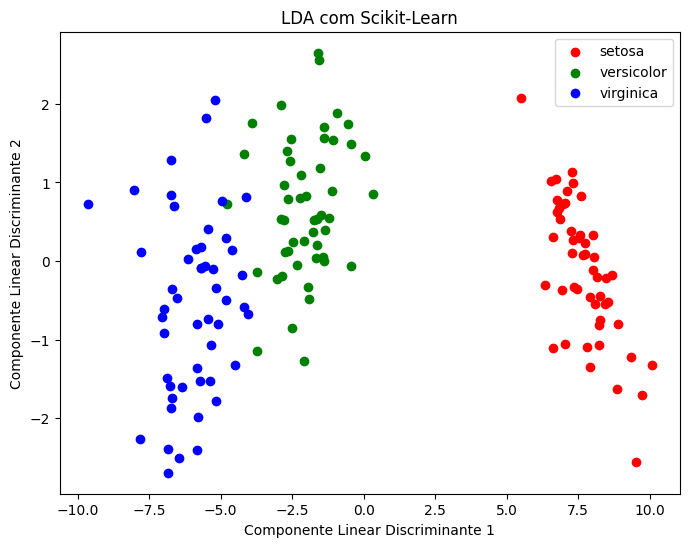

Coeficientes das variáveis nos componentes discriminantes:
                        LD1       LD2
sepal length (cm)  0.742899  0.210441
sepal width (cm)   1.831294 -2.273707
petal length (cm) -2.317335  0.671810
petal width (cm)  -2.547401 -2.550692


In [ ]:
# Aplicar LDA
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

# Avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Precisão do Modelo LDA:', accuracy)

# Transformar os dados para visualização
X_lda = lda.transform(X)

# Visualizar os dados transformados
plt.figure(figsize=(8,6))
classes = np.unique(y)
colors = ['red', 'green', 'blue']
for label, color in zip(classes, colors):
    plt.scatter(X_lda[y == label, 0], X_lda[y == label, 1], label=iris.target_names[label], c=color)
plt.xlabel('Componente Linear Discriminante 1')
plt.ylabel('Componente Linear Discriminante 2')
plt.title('LDA com Scikit-Learn')
plt.legend()
plt.show()

# Análise das contribuições das variáveis
coeficientes = lda.scalings_
feature_names = iris.feature_names
df_coef = pd.DataFrame(coeficientes, index=feature_names, columns=['LD1', 'LD2'])
print('Coeficientes das variáveis nos componentes discriminantes:')
print(df_coef)

## Criação de um Pipeline de Machine Learning
Crie um pipeline de machine learning que inclua pré-processamento, PCA, e um modelo de classificação. Utilize a biblioteca Scikit-Learn e avalie a performance do pipeline com validação cruzada.

In [ ]:
# Criação do pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Avaliação da performance com validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

print('Acurácia média do pipeline:', scores.mean())

Acurácia média do pipeline: 0.8933333333333333
